In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import stan
import nest_asyncio
nest_asyncio.apply()

In [86]:
# Load the data
df = pd.read_csv("../data/01-raw/test_scores.csv")
num_samples = 500

# Down sample the data
accepted = df[df['ACCPT1ST'] == 1].sample(num_samples)
rejected = df[df['ACCPT1ST'] == 0].sample(num_samples)
df_sub = pd.concat([accepted, rejected], axis=0)

# Down sample
# df_sub = df.sample(frac=0.2)

# Extract relevant features
relevant_features = ['SATMath', 'SATWriting', 'SATVerbal']
X = df_sub[relevant_features].copy().to_numpy()
Y = df_sub['ACCPT1ST'].copy().astype(np.int8).to_numpy()

# Normalize the data
X_std = np.zeros(X.shape)
for i in range(X.shape[1]):
    X_std[:, i] = (X[:,i] - X[:,i].mean()) / X[:, i].std()

# Make sure all columns are standardized properly
for i in range(X_std.shape[1]):
    assert np.round(X_std[:,i].mean(), 2) == 0.00
    assert np.round(X_std[:,i].std(), 2) == 1.00

# Horshoe Prior

In [58]:
X_std.shape

(1000, 3)

In [59]:
# prior guess for the number of relevant features
n, p = X_std.shape
p0 = 2 
tau0 = p0 / (p - p0) * 1 / np.sqrt(n)

data_dict = dict(
    n=n,                        # Number of data points
    d=p,                        # Number of features
    X=X_std,                    # Explanatory variable
    y=Y,                        # Response variable
    p_alpha_df=p-1,             # prior alpha degrees of freedom
    p_alpha_loc=0,              # prior alpha location
    p_alpha_scale=2.5,          # prior scale alpha
    p_beta_df=1,                # prior beta degrees of freedom
    p_beta_global_df=1,         # prior beta global degrees of freedom
    p_beta_global_scale=tau0    # prior beta global scale
)

In [60]:
model_code = """
data {
    int<lower=1> n;                     // number of data points
    int<lower=1> d;                     // explanatory variable dimension
    matrix[n, d] X;            // explanatory variable
    array[n] int <lower=0,upper=1> y;  // response variable
    int<lower=1> p_alpha_df;            // prior alpha degrees of freedom
    real p_alpha_loc;          // prior alpha location
    real p_alpha_scale;        // prior scale alpha
    int<lower=1> p_beta_df;             // prior beta degrees of freedom
    int<lower=1> p_beta_global_df;      // prior beta global degrees of freedom
    real p_beta_global_scale;  // prior beta global scale
}

parameters {

    // intercept
    real alpha;

    // auxiliary variables for the variance parameters
    vector[d] z;
    vector[d] lambda_r1;
    vector<lower=0>[d] lambda_r2;
    real tau_r1;
    real<lower=0> tau_r2;
}

transformed parameters {

    vector[d] lambda;           // local variance parameter
    real tau;                   // global variance parameter
    vector[d] beta;             // explanatory variable weights
    vector[n] eta;              // linear predictor

    lambda = lambda_r1 .* sqrt(lambda_r2);
    tau = tau_r1 * sqrt(tau_r2);
    beta = z .* (lambda*tau);
    eta = alpha + X * beta;
}

model {

    // student t prior for intercept
    alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);

    z ~ normal(0.0, 1.0);

    // half t priors for lambdas
    lambda_r1 ~ normal(0.0, 1.0);
    lambda_r2 ~ inv_gamma(0.5*p_beta_df, 0.5*p_beta_df);

    // half t priors for tau
    tau_r1 ~ normal(0.0, p_beta_global_scale);
    tau_r2 ~ inv_gamma(0.5*p_beta_global_df, 0.5*p_beta_global_df);

    // observation model
    y ~ bernoulli_logit(eta);
}

generated quantities {
    vector[n] log_lik;
    for (i in 1:n)
        log_lik[i] = bernoulli_logit_lpmf(y[i] | eta[i]);
}
"""

In [61]:
model = stan.build(model_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [62]:
fit = model.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  32% (2600/8000)
Sampling:  36% (2900/8000)
Sampling:  54% (4300/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000232 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000175 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.75 seconds.
  Adjust your expectations accordingly!
  Gra

In [63]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,z.1,z.2,...,log_lik.991,log_lik.992,log_lik.993,log_lik.994,log_lik.995,log_lik.996,log_lik.997,log_lik.998,log_lik.999,log_lik.1000
draws,,,,,,,,,,,,,,,,,,,,,
0,-696.726344,0.900366,0.101645,4.0,26.0,1.0,703.128877,0.014402,0.778628,0.550988,...,-0.691036,-0.522596,-0.577228,-0.682275,-0.759009,-0.627334,-0.845728,-0.641449,-0.606165,-0.759066
1,-695.022566,0.981962,0.091098,5.0,63.0,0.0,699.020098,0.094584,-1.746891,1.447393,...,-0.753022,-0.665880,-0.665064,-0.704445,-0.796280,-0.682794,-0.684390,-0.704257,-0.601741,-0.817294
2,-693.435763,0.999122,0.066184,5.0,31.0,0.0,701.529758,-0.012113,-0.716888,0.568622,...,-0.694685,-0.634277,-0.633453,-0.662513,-0.723100,-0.646416,-0.652247,-0.660556,-0.590938,-0.737912
3,-693.918754,0.408197,0.064515,6.0,63.0,0.0,702.539152,0.078882,1.949588,0.073905,...,-0.745171,-0.706278,-0.694848,-0.703631,-0.770722,-0.698493,-0.651715,-0.715682,-0.629850,-0.786126
4,-695.371373,0.885817,0.101645,4.0,15.0,0.0,704.475536,0.030039,0.962518,0.432517,...,-0.704385,-0.589934,-0.622938,-0.693124,-0.748679,-0.656309,-0.785791,-0.667094,-0.632445,-0.752778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-696.949428,0.994181,0.064515,5.0,63.0,0.0,703.245788,-0.102420,-0.878757,-1.296593,...,-0.652613,-0.641305,-0.628024,-0.622798,-0.665882,-0.625235,-0.569938,-0.637008,-0.576316,-0.675821
3996,-695.445340,0.942957,0.101645,5.0,31.0,0.0,696.537162,0.000232,0.776137,2.574895,...,-0.696138,-0.612301,-0.635200,-0.666526,-0.742222,-0.652206,-0.674381,-0.670946,-0.604830,-0.742125
3997,-695.650007,0.976769,0.091098,5.0,31.0,0.0,704.761343,0.057846,-0.770517,-0.842317,...,-0.734343,-0.703112,-0.694957,-0.690918,-0.762728,-0.693820,-0.623620,-0.713414,-0.624916,-0.771851


In [64]:
fit

<stan.Fit>
Parameters:
    alpha: ()
    z: (3,)
    lambda_r1: (3,)
    lambda_r2: (3,)
    tau_r1: ()
    tau_r2: ()
    lambda: (3,)
    tau: ()
    beta: (3,)
    eta: (1000,)
    log_lik: (1000,)
Draws: 4000

In [65]:
fit["beta"].shape

(3, 4000)

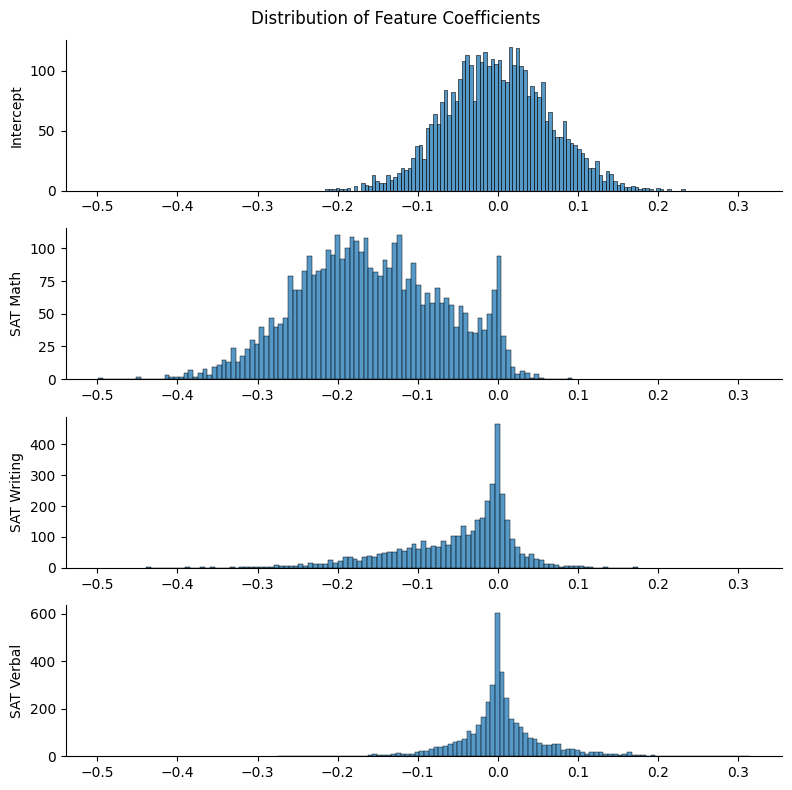

In [85]:
n_bins = 100

plot_labels = ["Intercept", "SAT Math", "SAT Writing", "SAT Verbal"]
plot_range = fit["beta"].shape[0]
plt.figure(figsize=(8, 8))

plt.suptitle("Distribution of Feature Coefficients")
ax1 = plt.subplot(plot_range+1, 1, 1)
sns.histplot(fit['alpha'].flatten(), bins=n_bins);
plt.ylabel("Intercept")

for j in range(1, plot_range+1):
  plt.subplot(plot_range+1,1, j + 1, sharex=ax1)
  sns.histplot(fit['beta'][j-1,:], bins=n_bins)
  sns.despine()
  plt.ylabel(plot_labels[j])

plt.tight_layout(pad=1)

In [93]:
dummy_df = pd.get_dummies(df_sub[['State', 'Yoursex:', 'Race/EthnicityGroup']], prefix=None, prefix_sep='_', dummy_na=False, dtype=np.int8)
dummy_mat = dummy_df.to_numpy()
dummy_features = list(dummy_df.columns)

X_full = np.concatenate([X_std, dummy_mat], axis=1)

In [98]:
n, p = X_full.shape
# prior guess for the number of relevant features
p0 = 5
tau0 = p0 / (p - p0) * 1 / np.sqrt(n)

data_dict = dict(
    n=n,                        # Number of data points
    d=p,                        # Number of features
    X=X_full,                    # Explanatory variable
    y=Y,                        # Response variable
    p_alpha_df=p-1,             # prior alpha degrees of freedom
    p_alpha_loc=0,              # prior alpha location
    p_alpha_scale=2.5,          # prior scale alpha
    p_beta_df=1,                # prior beta degrees of freedom
    p_beta_global_df=1,         # prior beta global degrees of freedom
    p_beta_global_scale=tau0    # prior beta global scale
)

In [99]:
model2 = stan.build(model_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [100]:
fit2 = model2.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [101]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,z.1,z.2,...,log_lik.991,log_lik.992,log_lik.993,log_lik.994,log_lik.995,log_lik.996,log_lik.997,log_lik.998,log_lik.999,log_lik.1000
draws,,,,,,,,,,,,,,,,,,,,,
0,-696.726344,0.900366,0.101645,4.0,26.0,1.0,703.128877,0.014402,0.778628,0.550988,...,-0.691036,-0.522596,-0.577228,-0.682275,-0.759009,-0.627334,-0.845728,-0.641449,-0.606165,-0.759066
1,-695.022566,0.981962,0.091098,5.0,63.0,0.0,699.020098,0.094584,-1.746891,1.447393,...,-0.753022,-0.665880,-0.665064,-0.704445,-0.796280,-0.682794,-0.684390,-0.704257,-0.601741,-0.817294
2,-693.435763,0.999122,0.066184,5.0,31.0,0.0,701.529758,-0.012113,-0.716888,0.568622,...,-0.694685,-0.634277,-0.633453,-0.662513,-0.723100,-0.646416,-0.652247,-0.660556,-0.590938,-0.737912
3,-693.918754,0.408197,0.064515,6.0,63.0,0.0,702.539152,0.078882,1.949588,0.073905,...,-0.745171,-0.706278,-0.694848,-0.703631,-0.770722,-0.698493,-0.651715,-0.715682,-0.629850,-0.786126
4,-695.371373,0.885817,0.101645,4.0,15.0,0.0,704.475536,0.030039,0.962518,0.432517,...,-0.704385,-0.589934,-0.622938,-0.693124,-0.748679,-0.656309,-0.785791,-0.667094,-0.632445,-0.752778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-696.949428,0.994181,0.064515,5.0,63.0,0.0,703.245788,-0.102420,-0.878757,-1.296593,...,-0.652613,-0.641305,-0.628024,-0.622798,-0.665882,-0.625235,-0.569938,-0.637008,-0.576316,-0.675821
3996,-695.445340,0.942957,0.101645,5.0,31.0,0.0,696.537162,0.000232,0.776137,2.574895,...,-0.696138,-0.612301,-0.635200,-0.666526,-0.742222,-0.652206,-0.674381,-0.670946,-0.604830,-0.742125
3997,-695.650007,0.976769,0.091098,5.0,31.0,0.0,704.761343,0.057846,-0.770517,-0.842317,...,-0.734343,-0.703112,-0.694957,-0.690918,-0.762728,-0.693820,-0.623620,-0.713414,-0.624916,-0.771851


In [118]:
def plot_betas(fit, n_bins=100, figsize=(8,8)):
    plot_labels = ["Intercept", "SAT Math", "SAT Writing", "SAT Verbal"]
    plot_range = fit["beta"].shape[0]
    plt.figure(figsize=figsize)

    plt.suptitle("Distribution of Feature Coefficients")
    ax1 = plt.subplot(plot_range+1, 1, 1)
    sns.histplot(fit['alpha'].flatten(), bins=n_bins);
    plt.xlim((-5,5))
    plt.ylabel("Intercept")

    for j in range(1, plot_range+1):
        plt.subplot(plot_range+1,1, j + 1, sharex=ax1)
        sns.histplot(fit2['beta'][j-1,:], bins=n_bins)
        sns.despine()
        plt.ylabel(plot_labels[j])

    plt.tight_layout()
    plt.tight_layout(pad=1)

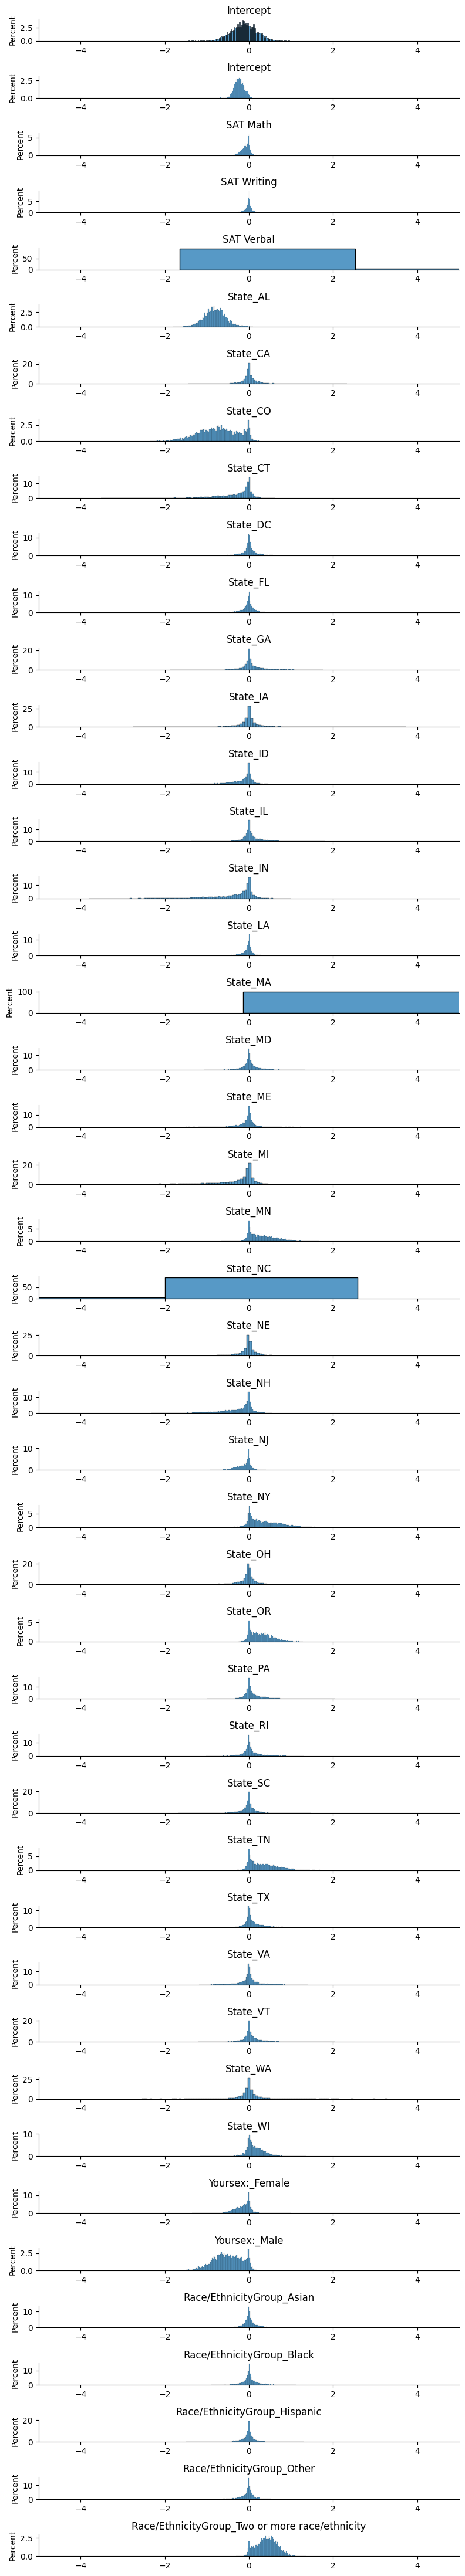

In [122]:
n_bins = 100

plot_labels = ["Intercept", "SAT Math", "SAT Writing", "SAT Verbal"]
plot_labels.extend(dummy_features)
plot_range = fit2["beta"].shape[0]
plt.figure(figsize=(8, 44))

# plt.suptitle("Distribution of Feature Coefficients")
ax1 = plt.subplot(plot_range+1, 1, 1)
sns.histplot(fit2['alpha'].flatten(), bins=n_bins, stat="percent");
plt.xlim((-5,5))
plt.title("Intercept")

for j in range(1, plot_range+1):
  plt.subplot(plot_range+1,1, j + 1, sharex=ax1)
  sns.histplot(fit2['beta'][j-1,:], bins=n_bins, stat="percent")
  sns.despine()
  plt.title(plot_labels[j-1])

plt.tight_layout()
plt.tight_layout(pad=1)

In [124]:
print(dummy_df["State_MA"].value_counts())
print(dummy_df["State_NC"].value_counts())

0    907
1     93
Name: State_MA, dtype: int64
0    948
1     52
Name: State_NC, dtype: int64


In [135]:
plot_labels.index("Intercept")

0

In [139]:
sns.histplot(fit2['beta'][plot_labels.index("State_MA"), :], stat="percent") #, bins=100, stat="percent")
plt.xlim((-5,5))